---------------

**If any part of this notebook is used in your research, please cite with the reference found in** **[README.md](https://github.com/pysal/spaghetti#bibtex-citation).**


----------------

## Network point pattern attributes
### Demonstrating network point pattern representation

**Author: James D. Gaboardi** **<jgaboardi@gmail.com>**

**This notebook is an basic walk-through for:**

1. Exploring the attributes of network objects and point patterns
2. Generating observation counts per network link
3. Simulating a point pattern

In [1]:
%config InlineBackend.figure_format = "retina"

In [2]:
%load_ext watermark
%watermark

Last updated: 2021-06-25T18:24:22.505391-04:00

Python implementation: CPython
Python version       : 3.9.4
IPython version      : 7.24.1

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 20.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [3]:
import geopandas
import libpysal
import matplotlib
import matplotlib_scalebar
from matplotlib_scalebar.scalebar import ScaleBar
import numpy
import pandas
import shapely
from shapely.geometry import Point
import spaghetti

%matplotlib inline
%watermark -w
%watermark -iv

Watermark: 2.2.0

matplotlib         : 3.4.2
libpysal           : 4.4.0
matplotlib_scalebar: 0.7.2
geopandas          : 0.9.0
shapely            : 1.7.1
numpy              : 1.20.3
json               : 2.0.9
spaghetti          : 1.6.1
pandas             : 1.2.3



----------------

### Instantiating a `spaghetti.Network` object
#### Instantiate the network from a `.shp` file

In [4]:
ntw = spaghetti.Network(in_data=libpysal.examples.get_path("streets.shp"))

------------------------------
### 1. Allocating observations (snapping points) to a network:

**A network is composed of a single topological representation of network elements (arcs and vertices) to which point patterns may be snapped.**

In [5]:
pp_name = "crimes"
pp_shp = libpysal.examples.get_path("%s.shp" % pp_name)
ntw.snapobservations(pp_shp, pp_name, attribute=True)
ntw.pointpatterns

{'crimes': <spaghetti.network.PointPattern at 0x10e8655e0>}

#### Attributes for every point pattern

1. ``dist_snapped`` dict keyed by point id with the value as snapped distance from observation to network arc

In [6]:
ntw.pointpatterns[pp_name].dist_snapped[0]

221.58676169738433

2. ``dist_to_vertex`` dict keyed by pointid with the value being a dict in the form 
        {node: distance to vertex, node: distance to vertex}

In [7]:
ntw.pointpatterns[pp_name].dist_to_vertex[0]

{161: 83.70599311338091, 162: 316.8274480625799}

3. ``npoints`` point observations in set

In [8]:
ntw.pointpatterns[pp_name].npoints

287

4. ``obs_to_arc`` dict keyed by arc with the value being a dict in the form 
        {pointID:(x-coord, y-coord), pointID:(x-coord, y-coord), ... }

In [9]:
ntw.pointpatterns[pp_name].obs_to_arc[(161, 162)]

{0: (727919.2473619275, 875942.4986759046)}

5. ``obs_to_vertex`` list of incident network vertices to snapped observation points

In [10]:
ntw.pointpatterns[pp_name].obs_to_vertex[0]

161

6. ``points`` geojson like representation of the point pattern.  Includes properties if read with attributes=``True``

In [11]:
ntw.pointpatterns[pp_name].points[0]

{'coordinates': (727913.0000000029, 875720.9999999977), 'properties': [[1, 1]]}

7. ``snapped_coordinates`` dict keyed by pointid with the value being (x-coord, y-coord)

In [12]:
ntw.pointpatterns[pp_name].snapped_coordinates[0]

(727919.2473619275, 875942.4986759046)

------------------------------
### 2. Counts per link

**Counts per link (arc or edge) are important, but should not be precomputed since there are spatial and graph representations.**

In [13]:
def fetch_cpl(net, pp, mean=True):
    """Create a counts per link object and find mean."""
    cpl = net.count_per_link(net.pointpatterns[pp].obs_to_arc, graph=False)
    if mean:
        mean_cpl = sum(list(cpl.values())) / float(len(cpl.keys()))
        return cpl, mean_cpl
    return cpl

In [14]:
ntw_counts, ntw_ctmean = fetch_cpl(ntw, pp_name)
list(ntw_counts.items())[:4]

[((161, 162), 1), ((157, 158), 3), ((162, 163), 2), ((160, 161), 2)]

In [15]:
ntw_ctmean

2.682242990654206

----------------------------

### 3. Simulate a point pattern on the network

 * **The number of points must supplied.**
 * **The only distribution currently supported is uniform.**
 * **Generally, this will not be called by the user since the simulation will be used for Monte Carlo permutation.**

In [16]:
npts = ntw.pointpatterns[pp_name].npoints
npts

287

In [17]:
sim_uniform = ntw.simulate_observations(npts)
sim_uniform

In [18]:
print(dir(sim_uniform))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'dist_to_vertex', 'npoints', 'obs_to_arc', 'obs_to_vertex', 'points', 'snapped_coordinates']


#### Extract the simulated points along the network a ``geopandas.GeoDataFrame``

In [19]:
def as_gdf(pp):
    pp = {idx: Point(coords) for idx, coords in pp.items()}
    df = pandas.DataFrame.from_dict(pp, orient="index")
    df.index.name, df.columns = "id", ["geometry"]
    gdf = geopandas.GeoDataFrame(df, geometry=df.geometry)
    return gdf

sim_uniform_gdf = as_gdf(sim_uniform.points)
sim_uniform_gdf.head()

,geometry
id,
0,POINT (728144.595 880959.110)
1,POINT (725623.498 877982.725)
2,POINT (728612.710 876518.889)
3,POINT (724633.378 880984.638)
4,POINT (728502.691 875931.577)


#### Create ``geopandas.GeoDataFrame`` objects of the vertices and arcs

In [20]:
vertices_df, arcs_df = spaghetti.element_as_gdf(
    ntw, vertices=ntw.vertex_coords, arcs=ntw.arcs
)

#### Create ``geopandas.GeoDataFrame`` objects of the actual and snapped crime locations

In [21]:
crimes = spaghetti.element_as_gdf(ntw, pp_name=pp_name)
crimes_snapped = spaghetti.element_as_gdf(ntw, pp_name=pp_name, snapped=True)

#### Helper plotting function

In [22]:
def plotter():
    """Generate a spatial plot."""
    
    def _patch(_kws, labinfo):
        """Generate a legend patch."""
        label = "%s — %s" % tuple(labinfo)
        _kws.update({"lw":0, "label":label, "alpha":.5})
        return matplotlib.lines.Line2D([], [], **_kws)
    
    def _legend(handles, anchor=(1., .75)):
        """Generate a legend."""
        lkws = {"fancybox":True,"framealpha":0.85, "fontsize":"xx-large"}
        lkws.update({"bbox_to_anchor": anchor, "labelspacing": 2.})
        lkws.update({"borderpad": 2., "handletextpad":1.5})
        lkws.update({"title": "Crime locations & counts", "title_fontsize":25})
        matplotlib.pyplot.legend(handles=handles, **lkws)
    
    def carto_elements(b):
        """Add/adjust cartographic elements."""
        kw = {"units":"ft", "dimension":"imperial-length", "fixed_value":1000}
        b.add_artist(ScaleBar(1, **kw))
        b.set(xticklabels=[], xticks=[], yticklabels=[], yticks=[]);
    
    pkws = {"alpha":0.25}
    base = arcs_df.plot(color="k", figsize=(9, 9), zorder=0, **pkws)
    patches = []
    gdfs = [crimes, crimes_snapped, sim_uniform_gdf]
    colors, zo = ["k", "g", "b"], [1 ,2 ,3]
    markers, markersizes = ["o", "X", "X"], [150, 150, 150]
    labels = [["Empirical"], ["Network-snapped"], ["Simulated"]]
    iterinfo = list(zip(gdfs, colors, zo, markers, markersizes, labels))
    for gdf, c, z, m, ms, lab in iterinfo:
        gdf.plot(ax=base, c=c, marker=m, markersize=ms, zorder=z, **pkws)
        patch_args = {"marker":m, "markersize":ms/10,"c":c}, lab+[gdf.shape[0]]
        patches.append(_patch(*patch_args))
    _legend(patches)
    carto_elements(base)

#### Crimes: empirical, network-snapped, and simulated locations

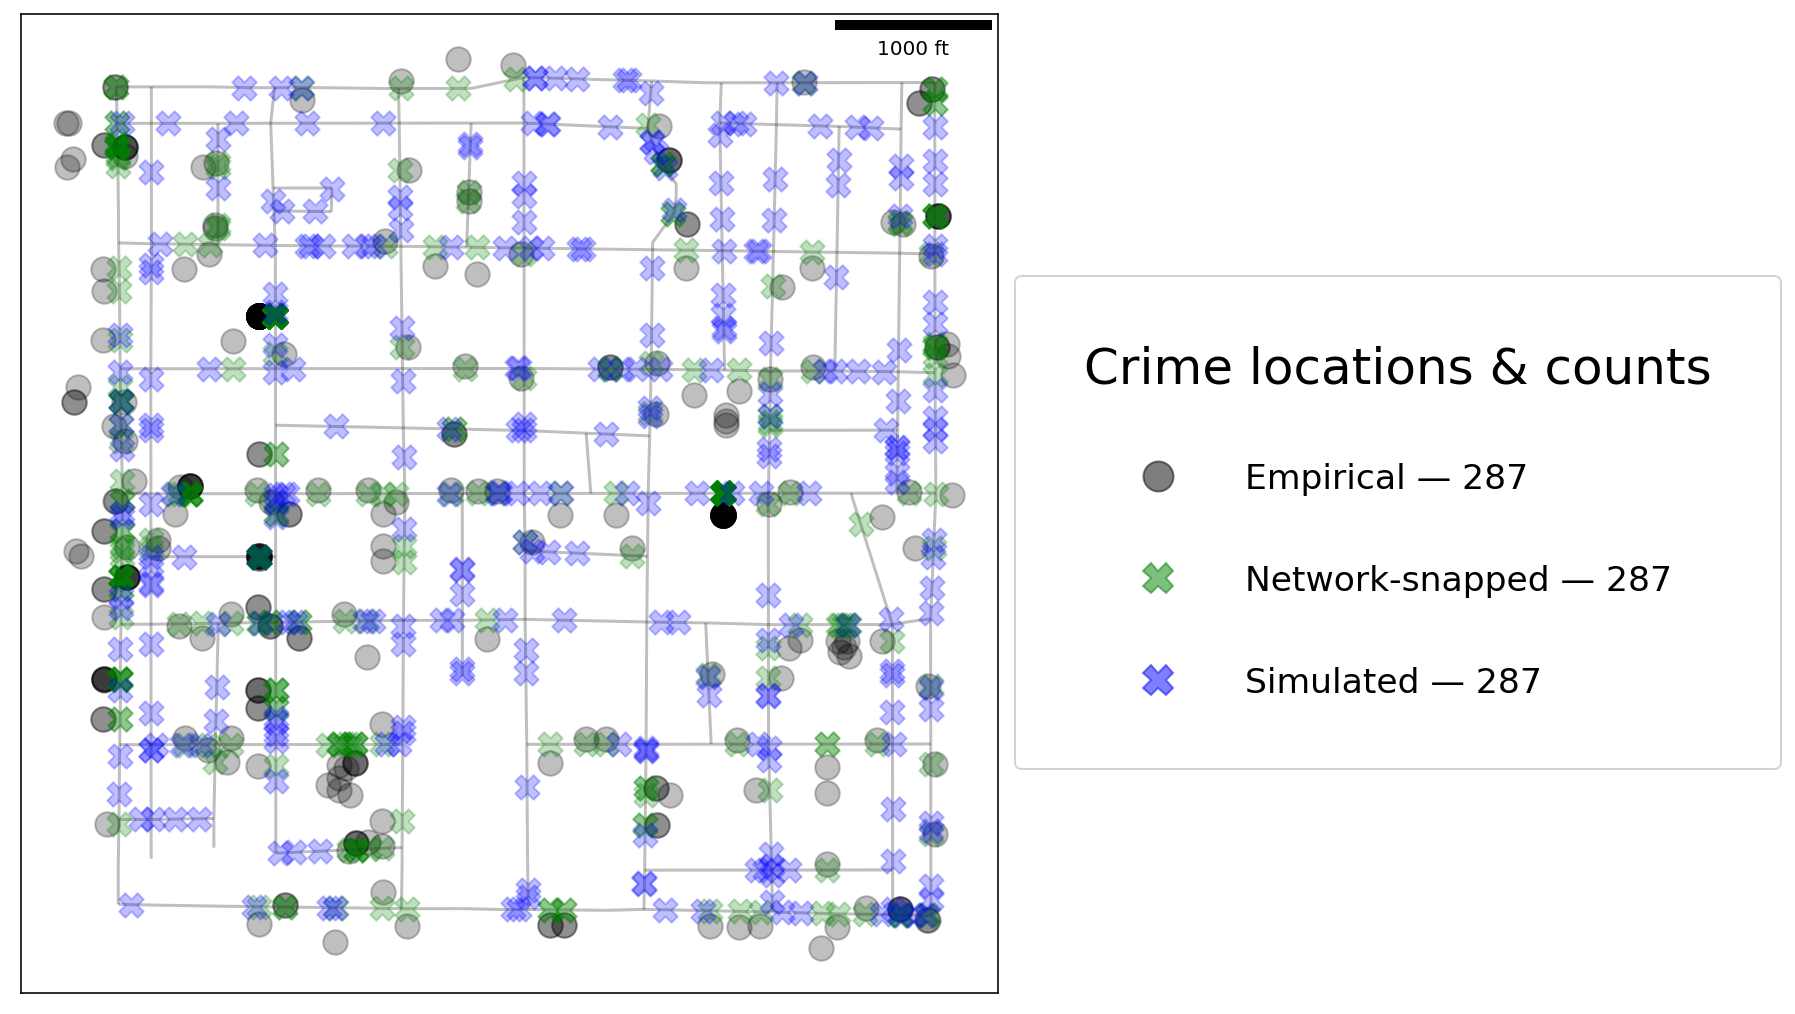

In [23]:
plotter()

------------------